# Training Neural Network using Transfer Learning

In this lab we will recognize the view in slices of the adult mouse brain (M. musculus P56) as before but use transfer learning. This is supplemental material to the base lesson.  

![three_main_anatomical_planes](images/three_main_anatomical_planes.png)

_The  three main anatomical planes exemplified on human brain sketch_

In order to describe the location of structures, mouse brains are often sliced across one of the three main anatomical planes: sagittal, coronal and horizontal (see top-right figure).. Example of slices for adult mouse brains are shown below (source: BrainMaps http://brainmaps.org/index.php?p=speciesdata&species=mus-musculus).

![sagittal_coronal_horizontal](images/sagittal_coronal_horizontal.png)

_The anatomical, coronal, and sagittal planes of a mouse brain _

In this lab we will be recognizing the view (ie whether anatomical, coronal of sagittal) in a  set of images from BrainMaps.  

* We preprocessed the images so that the input os a numpy tensor of shape (N, 512, 512, 3) where N is the number of RGB images of size (512, 512).  

* The classifier should output a vector of size (3,) and dtype float containing the probabilities of the image being sliced horizontally, coronally and sagittally respectively.


These lessons are adapted from submissions to the [Broad Institute of MIT and Harvard and NEU AI Skunkworks Mouse Brain Challenge]( https://www.skonks.com/post/broad-institute-of-mit-and-harvard-and-neu-ai-skunkworks-mouse-brain-challenge) 
by [NEU Skunkworks](https://github.com/skunkworksneu)   
which are published under the [MIT License](https://opensource.org/licenses/MIT) which allows very broad use for both academic and commercial purposes.


AThe primary author of this notebook is Raghav Avasthi (https://www.linkedin.com/in/raghav-avasthi/, https://github.com/RaghavAvasthi) with revisions by Nicholas Brown https://github.com/nikbearbrown

We also like to thank the Broad Institute of MIT and Harvard and NEU AI Skunkworks Mouse Brain Challenge (https://www.skonks.com/post/broad-institute-of-mit-and-harvard-and-neu-ai-skunkworks-mouse-brain-challenge) 

## Transfer Learning

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. In transfer learning, we first train a base network on a base dataset and task, or download an existing model trained for another task.

It is unlikely that the input and output for the original and new tasks are identical so some features of the network changed. Larger changes such as activation functions, cost function, etc can also be done.  The primary information that is being transfered from the original to repurposed model are the weights and biases.

It is a popular approach in deep learning as training a model can take a long time. It is especially popular when using CNNs as the first couple of convolutional layers are detecting primative shapes such and horizantial and vertical lines and these convolutions are likley to be useful in many image recognition tasks.

There are many pre-trained models of this type, but the most popular include:

Oxford VGG Model http://www.robots.ox.ac.uk/~vgg/research/very_deep/   
Google Inception Model https://github.com/tensorflow/models/tree/master/research/inception  
Microsoft ResNet Model https://github.com/KaimingHe/deep-residual-networks  

Many more models can be found at Model Zoo

https://github.com/BVLC/caffe/wiki/Model-Zoo


## MobileNet V2 Architecture

MobileNetV2, there are two types of blocks. One is residual kernal with stride of 1.   
Another one is kernal with stride of 2 for downsizing.  

There are 3 layers for both types of blocks.   

* The first layer is 1×1 convolution with ReLU6 
* The second layer is the depthwise convolution  
* The third layer is another 1×1 convolution but without any non-linearity.

It is claimed that if ReLU is used again, the deep networks only have the power of a linear classifier on the non-zero volume part of the output domain.


![MobileNet V2 Architecture](images/MobileNet_V2.png)
_MobileNet V2 Architecture_
from the paper _MobileNet V2: Inverted Residuals and Linear Bottlenecks_ https://arxiv.org/abs/1801.04381 

For more detail see:

* _MobileNetV2: The Next Generation of On-Device Computer Vision Networks_ 
https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html   
* _MobileNet V2: Inverted Residuals and Linear Bottlenecks_ https://arxiv.org/abs/1801.04381  




## Benefits of using Transfer Learning and MobileNet V2

### 1) Good Accuracy with Less Data
Since, in transfer learning instead of training filters we copy them from other networks which were trained on huge sets of data, the filters we get are well trained. Thus, helping us get better accuracy than possible with our limited data

### 2) Ease of Deployment on Cloud for Production
MobileNet V2 is one of the most advanced neural network present which was trained on ImageNet 1000 and optimised for memory and speed using post-training optimization techniques. Transfer learning this network for our purpose not only gives us good accuracy but results in a neural network which is light in memory and has fast execution times. When deployed on cloud, this would prove to be very cost effective.


## Problems with using MobileNet V2

### 1) Define for Mobile Efficiency as Oppossed to Maximum Accuracy  
This is a odd choice given the problem.  The point of this is not to be effecient on a mobile device but to be as effecient as possible.  

In [1]:
"""
Created on Tue Sep  3 17:39:02 2019

@author: Raghav Avasthi
"""

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\MyPrograms\Anaconda3\envs\keras36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\MyPrograms\Anaconda3\envs\keras36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\MyPrograms\Anaconda3\envs\keras36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\MyPrograms\Anaconda3\envs\keras36\lib\site-packages\tensorflow\pyth

In [2]:
# Defining paths of directories holding data for training and validation
data_dir = r"C:\Users\Raghav Avasthi\Desktop\mouse brain\Brain_Dataset_Color_Pre" 
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validate')

In [3]:
image_size = 224 # All images will be resized to 224 x 224
batch_size = 32 # Refers to the number of images which will be trained on, together

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use categorical_crossentropy loss, we need categorical labels
                class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 737 images belonging to 3 classes.
Found 144 images belonging to 3 classes.


In [4]:
IMG_SHAPE = (image_size, image_size, 3)
# Create the base model from the pre-trained model MobileNet V2
# The base model does not have the classification layer. It only carries the trained weights from the filters
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Creating a new classification layer to be put over the base layer from MobileNet V2
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(3, activation='softmax') 
])

# Compiling the new classification layer over the trained layers from MobileNet V2
model.compile(optimizer=tf.keras.optimizers.Adam(), # Defining the optimizer, ADAM proves to be the best in such situations
              loss='categorical_crossentropy', # Defining this specific loss as there are more than 2 classes and it's a classification problem
              metrics=['accuracy'])

In [6]:
epochs = 8
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

# Training the netwrok and saving the train log
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
24/24 [==============================] - 207s 9s/step - loss: 0.5829 - acc: 0.7598 - val_loss: 0.7428 - val_acc: 0.7222
Epoch 2/8
24/24 [==============================] - 205s 9s/step - loss: 0.2422 - acc: 0.9498 - val_loss: 0.7037 - val_acc: 0.7222
Epoch 3/8
24/24 [==============================] - 207s 9s/step - loss: 0.1617 - acc: 0.9756 - val_loss: 0.7446 - val_acc: 0.6944
Epoch 4/8
24/24 [==============================] - 195s 8s/step - loss: 0.2560 - acc: 0.9688 - val_loss: 0.3950 - val_acc: 0.8194
Epoch 5/8
24/24 [==============================] - 200s 8s/step - loss: 0.1602 - acc: 0.9647 - val_loss: 0.7903 - val_acc: 0.7361
Epoch 6/8
24/24 [==============================] - 205s 9s/step - loss: 0.1264 - acc: 0.9810 - val_loss: 0.6211 - val_acc: 0.7222
Epoch 7/8
24/24 [==============================] - 200s 8s/step - loss: 0.1771 - acc: 0.9769 - val_loss: 0.5022 - val_acc: 0.7917
Epoch 8/8
24/24 [=========================

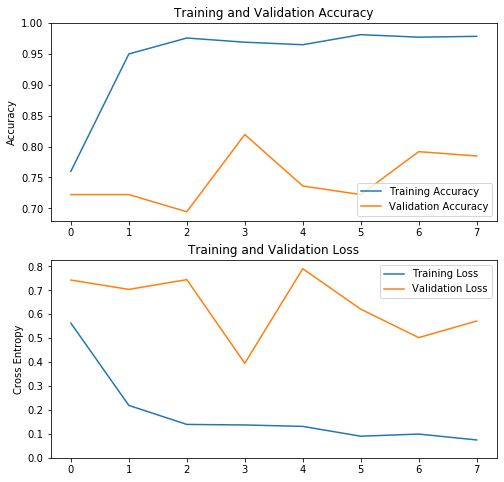

In [7]:
# Displaying the graphs showing comparisons between training and validation accuracy and loss respectively
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Overfitting 

While the training data is plateauing, the validation data is still very unstable.  This network does not look like it has converged.  

## Fine Tuning the Network 

The concept of fin tuning extends the idea of transfer learning as it argues that one can unfreeze the base layers and train a few of them to get better accuracy. The idea originates from the observation that early filters in CNN learn very basic and general patterns and as you deeper into the neural network, the filters learn more complex and data orieanted features and patterns. Thus, one can retrain or say tweak the deeper layers to get better accuracy for one's custom dataset. 

In [8]:
base_model.trainable = True

In [9]:
# MobileNet V2 has 155 layers, here we choose to freeze the first 100 layers and unfreeze the rest
fine_tune_at = 100 

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/8
24/24 [==============================] - 292s 12s/step - loss: 0.1539 - acc: 0.9647 - val_loss: 0.8112 - val_acc: 0.8264
Epoch 2/8
24/24 [==============================] - 281s 12s/step - loss: 0.2322 - acc: 0.9919 - val_loss: 1.8415 - val_acc: 0.7708
Epoch 3/8
24/24 [==============================] - 287s 12s/step - loss: 0.3015 - acc: 0.9905 - val_loss: 0.9318 - val_acc: 0.9097
Epoch 4/8
24/24 [==============================] - 288s 12s/step - loss: 0.1516 - acc: 0.9959 - val_loss: 1.8433 - val_acc: 0.7431
Epoch 5/8
24/24 [==============================] - 296s 12s/step - loss: 0.2995 - acc: 0.9891 - val_loss: 2.1199 - val_acc: 0.8056
Epoch 6/8
24/24 [==============================] - 287s 12s/step - loss: 0.0418 - acc: 1.0000 - val_loss: 3.6110 - val_acc: 0.5625
Epoch 7/8
24/24 [==============================] - 294s 12s/step - loss: 0.1202 - acc: 0.9986 - val_loss: 1.4032 - val_acc: 0.7292
Epoch 8/8
24/24 [==============================] - 294s 12s/step - loss: 0.1157 - a

In [12]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

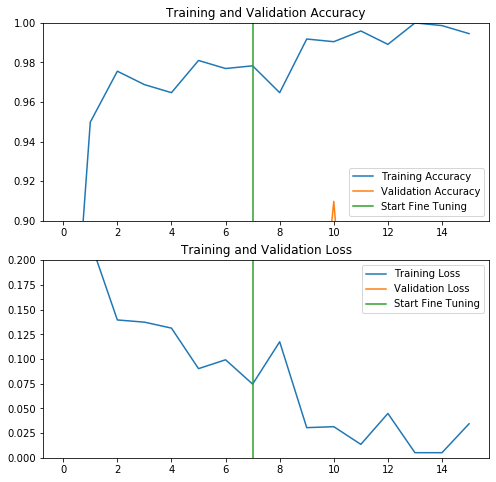

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusions

This model did far worse than the simple model or the data augmented model. All those models were 90+% accuracy on out of sample data.  This model varied from 70-80% on out of sample data. This may have to do with a poor choice of original model, MobileNet V2, or an undertrained model.  

## Acknowledgements

The primary author of this notebook is Raghav Avasthi (https://www.linkedin.com/in/raghav-avasthi/, https://github.com/RaghavAvasthi) with revisions by Nicholas Brown https://github.com/nikbearbrown

In addition there were contributions by Nikunj Lad (https://www.linkedin.com/in/nikunjlad/, https://github.com/nikunjlad), Raghav Avasthi (https://www.linkedin.com/in/raghav-avasthi/, https://github.com/RaghavAvasthi), Ziqing Lu (https://www.linkedin.com/in/ziqinglu/, https://github.com/ziqlu0722)  

We also like to thank the Broad Institute of MIT and Harvard and NEU AI Skunkworks Mouse Brain Challenge (https://www.skonks.com/post/broad-institute-of-mit-and-harvard-and-neu-ai-skunkworks-mouse-brain-challenge) 